In [1]:
# Import the libraries and functions
from functions import *

## 1. Overview

In [2]:
# Set the maximum width of the columns
pd.set_option('display.max_colwidth', 20)

In [3]:
# Load a dataframe of the disordered regions
disordered = pd.read_csv('disordered_df.csv')
curated_disprot = pd.read_csv('curated_disprot.csv')
print(f'The number of rows with the disordered regions: {len(disordered)}')
disordered.head()

The number of rows with the disordered regions: 7393


,query_id,subject_id,query_len,hsp_len,query_seq,subject_seq,query_start,query_end,subject_start,subject_end,eval,bit_score,count
0,Q9H832,A0A6J2FM24,354,356,MAESPTEEAATA--GA...,MAESPTEEAATATAGA...,1,354,1,354,0.0,1851.0,200
1,Q9H832,A0A3Q7W6Y2,354,356,MAESPTEEAATA--GA...,MAESPTEEAATATAGA...,1,354,1,354,0.0,1851.0,200
2,Q9H832,A0A2U3VK69,354,356,MAESPTEEAATA--GA...,MAESPTEEAATATAGA...,1,354,1,354,0.0,1851.0,200
3,Q9H832,A0A2Y9JVH5,354,358,MAESPTEEAATA----...,MAESPTEEAATATATA...,1,354,1,356,0.0,1854.0,200
4,Q9H832,A0A8C7ALE4,354,358,MAESPTEEAATA----...,MAESPTEEAATATATA...,1,354,1,356,0.0,1854.0,200


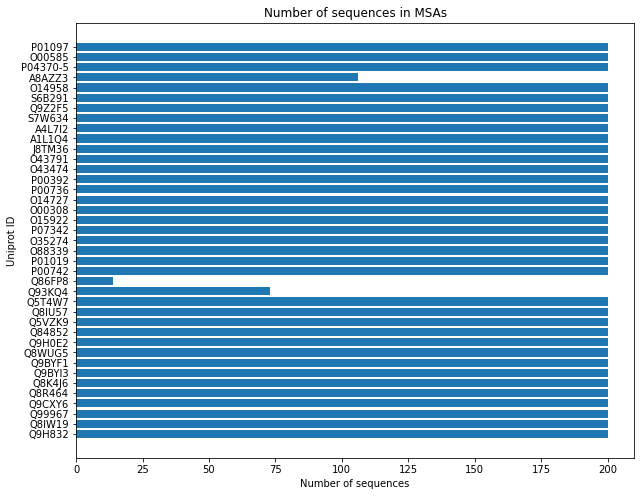

In [10]:
# Plot the number of sequences in each MSA
figure(figsize=(10, 8))
plt.barh(disordered['query_id'], disordered['count'])
plt.xlabel('Number of sequences')
plt.ylabel('Uniprot ID')
plt.title('Number of sequences in MSAs')
plt.show()

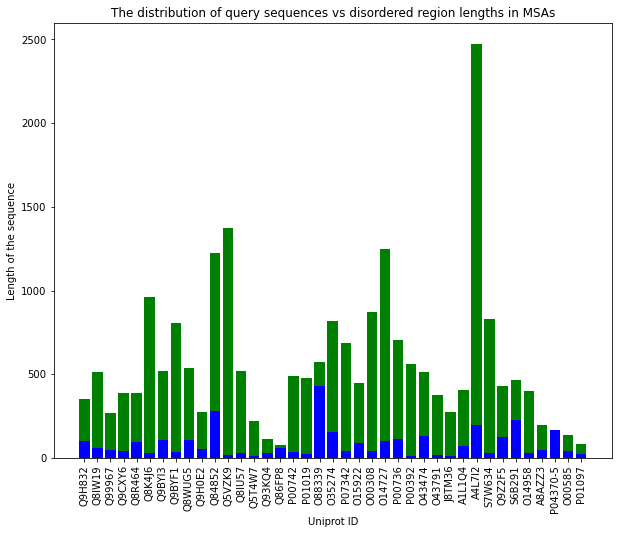

In [7]:
# Select only the information from the disordered dataframe
cur_filt = curated_disprot[curated_disprot['acc'].isin(disordered['query_id'])]

# Plot the length of sequences and the disordered regions of the MSAs
figure(figsize=(10, 8))
plt.bar(disordered['query_id'], disordered['query_len'], color='green')
plt.bar(cur_filt['acc'], cur_filt['length'], color='blue')
plt.tick_params(axis='x', labelrotation=90)
plt.xlabel('Uniprot ID')
plt.ylabel('Length of the sequence')
plt.title('The distribution of query sequences vs disordered region lengths in MSAs')
plt.show()

In [8]:
# # Plot HSP length count
# figure(figsize=(10, 8))
# plt.scatter(disordered['hsp_len'], disordered['query_id'], alpha=0.4)
# plt.xlabel('HSP length')
# plt.ylabel('Uniprot ID')
# plt.title('HSP lengths count')
# plt.show()

### 2. Query ID Analysis

Next, we determine the count of subject IDs for each query ID. It's important to note that we need to summarize the data for all subject IDs that occurred for a particular query, rather than for each individual 'query-sequence' pair.

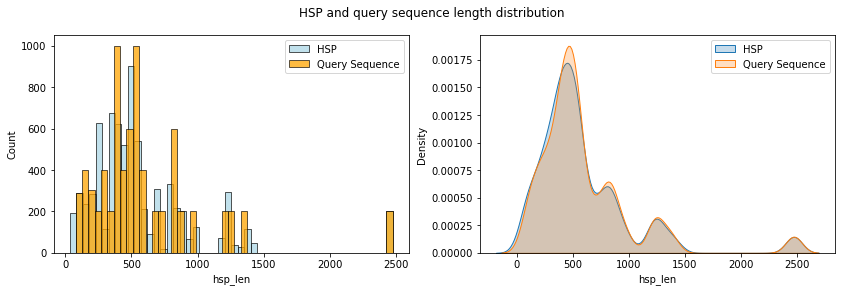

In [9]:
# Create bar plot and KDE plot for HSP hits
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(disordered['hsp_len'], kde = False, bins = 50, color = 'lightblue', ax = ax1, label='HSP')
sns.histplot(disordered['query_len'], kde = False, bins = 50, color = 'orange', ax = ax1, label='Query Sequence')
sns.kdeplot(disordered['hsp_len'], shade = True, ax = ax2, label='HSP')
sns.kdeplot(disordered['query_len'], shade = True, ax = ax2, label='Query Sequence')
ax1.legend()
ax2.legend()
plt.suptitle(f'HSP and query sequence length distribution')
plt.show()

The `histplot` shows the distribution of HSP lengths in the selected query ID by grouping the HSP lengths into bins or ranges along the x-axis and displaying the frequency of HSP lengths as the height of the corresponding bar on the y-axis.

The height of the `kdeplot` curve represents the estimated probability density of the variable being plotted at each point on the x-axis. For example, in the case of the HSP length, the height of the curve at a particular value of x represents the estimated density of observations around that value. The area under the curve represents the total probability of all possible values of the variable, which is equal to 1.

The `violinplot` provides the information about the interquartile range (thick gray line), median that is represented by a white dot and the rest of a distribution (thin gray line). The distribution's shape is presented on either side of the gray line through kernel density estimation. The wider sections of the violin plot represent a greater probability of the population taking on a specific value, while the narrower sections indicate a lower probability.

## 3. Multiple Sequence Alignment

Within this framework, we will compare the MSA results obtained directly from the BLAST output with those generated from the ClustalOmega service.

### Removing redundant regions

For this step we use the input files for ClustalOmega alignment. The goal is to keep only non-redundant regions. We set the threshold for redundancy of 90%. The program implementing the task is called `cd-hit`.

Next, we will be working with the newly generated file. It will be uploaded to ebi website, where we will select Pearson/FASTA as the output format. Once we have downloaded the aligned sequences, we can analyze the alignment using Jalview.

In [11]:
# # Create a dataframe with the calculated redundancy
# redundancy_df = pd.read_csv('nr_75.csv', sep=';')
# redundancy_df.head()

In [12]:
# # Plot the redundancy distribution
# figure(figsize=(6, 4))
# plt.plot(redundancy_df['id'], redundancy_df['ratio'])
# plt.xlabel('Uniprot ID')
# plt.ylabel('Ratio')
# plt.xticks(rotation='vertical')
# plt.title('Distribution of redundancy of MSA')
# plt.show()

In [15]:
# Set the path for the clusters files
blast_clstr_path = f'{directory}/results/alignments/output_files/blast/non-redundant'
clustal_clstr_path = f'{directory}/results/alignments/output_files/clustal/non-redundant'

In [79]:
# Plot dendrograms for MSAs
def plot_dendrograms(clstr_path, ali):
    for cluster_filename in os.listdir(clstr_path):
        if cluster_filename.endswith('.clstr'):
            cluster_path = os.path.join(clstr_path, cluster_filename)

            cluster_data = []
            with open(cluster_path, 'r') as file:
                for line in file:
                    if line.startswith('>Cluster'):
                        continue
                    parts = line.strip().split('\t')
                    percentage_matches = re.findall(r'\d+\.\d+', parts[-1])
                    if percentage_matches:
                        percentage = float(percentage_matches[0])
                        cluster_data.append(percentage)

            # Check if there are at least two observations
            if len(cluster_data) < 2:
                continue

            # Convert the data into a matrix
            matrix_data = np.array(cluster_data).reshape(len(cluster_data), 1)

            # Create linkage matrix using the data and hierarchical clustering
            Z = linkage(matrix_data, method='average')

            prot = cluster_path.split('_')[1].split('/')[3]

            # Plot the dendrogram
            plt.figure(figsize=(10, 6))
            dendrogram(Z, labels=np.arange(len(cluster_data)), leaf_rotation=90, leaf_font_size=8)

            # Add a horizontal line for the threshold
            threshold = 5.0
            plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold}%)')

            plt.title(f'Hierarchical Clustering Dendrogram - {ali}')
            plt.xlabel(f'Dendrogram of the {prot} MSA')
            plt.ylabel('Distance')
            plt.show()
            break

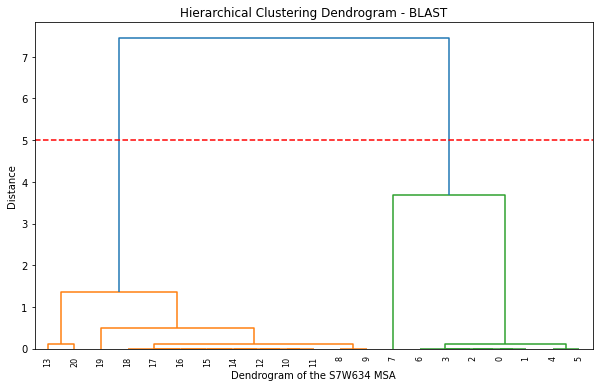

In [80]:
# Plot dendrograms for BLAST results
plot_dendrograms(blast_clstr_path, 'BLAST')

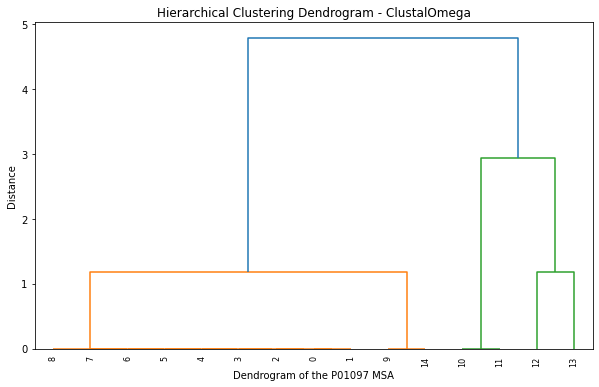

In [72]:
# Plot dendrograms for Clustal_Omega results
plot_dendrograms(clustal_clstr_path, 'ClustalOmega')

In [14]:
# cluster_data = []
# with open(data_file, 'r') as file:
#     for line in file:
#         if line.startswith('>Cluster'):
#             continue
#         parts = line.strip().split('\t')
#         percentage_matches = re.findall(r'\d+\.\d+', parts[-1])
#         if percentage_matches:
#             percentage = float(percentage_matches[0])
#             cluster_data.append(percentage)

# # Convert the data into a matrix
# matrix_data = np.array(cluster_data).reshape(len(cluster_data), 1)

# # Create linkage matrix using the data and hierarchical clustering
# Z = linkage(matrix_data, method='average')

# # Plot the dendrogram
# plt.figure(figsize=(10, 6))
# dendrogram(Z, labels=np.arange(len(cluster_data)), leaf_rotation=90, leaf_font_size=8)

# # Add a horizontal line for the threshold
# threshold = 10.0
# plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold}%)')

# plt.title('Hierarchical Clustering Dendrogram')
# plt.xlabel(f'Cluster Index for {id_split} protein')
# plt.ylabel('Distance')
# plt.show()

## 4. Analysing the quality of prediction

For calculation of the entropy we use a probability distribution with 20 outcomes, where each outcome has an equal probability of 1/20. Entropy is a measure of the uncertainty or randomness associated with a probability distribution. In this case, since the probability distribution is uniform, the entropy is maximized, meaning that there is maximum uncertainty or randomness associated with the outcomes.

With occupancy we define the proportion of non-missing (non-gap) values in the column.

### 4.1. Analysis of occupancy and entropy for MSA (redundant and non-redundant)

Here we will build KDE plots of the occupancy and entropy.

In [22]:
# Load the data with statistics
%store -r blast_stats clustal_stats

In [25]:
# # KDE plot of occupancy/entropy - general
# fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# sns.kdeplot(blast_stats['occupancy'], shade = True, ax = ax[0], label='BLAST')
# sns.kdeplot(clustal_stats['occupancy'], shade = True, ax = ax[0], label='ClustalOmega')
# sns.kdeplot(blast_stats['entropy'], shade = True, ax = ax[1], label='BLAST')
# sns.kdeplot(clustal_stats['entropy'], shade = True, ax = ax[1], label='ClustalOmega')

# # Add x-axis labels to all subplots
# x_axis_labels = ['Occupancy', 'Entropy']
# for i in range(2):
#     ax[i].set_xlabel(x_axis_labels[i])

# plt.legend()

# plt.suptitle(f'Occupancy and entropy distribution for BLAST and ClustalOmega alignments (overall)')
# plt.tight_layout()
# plt.show()

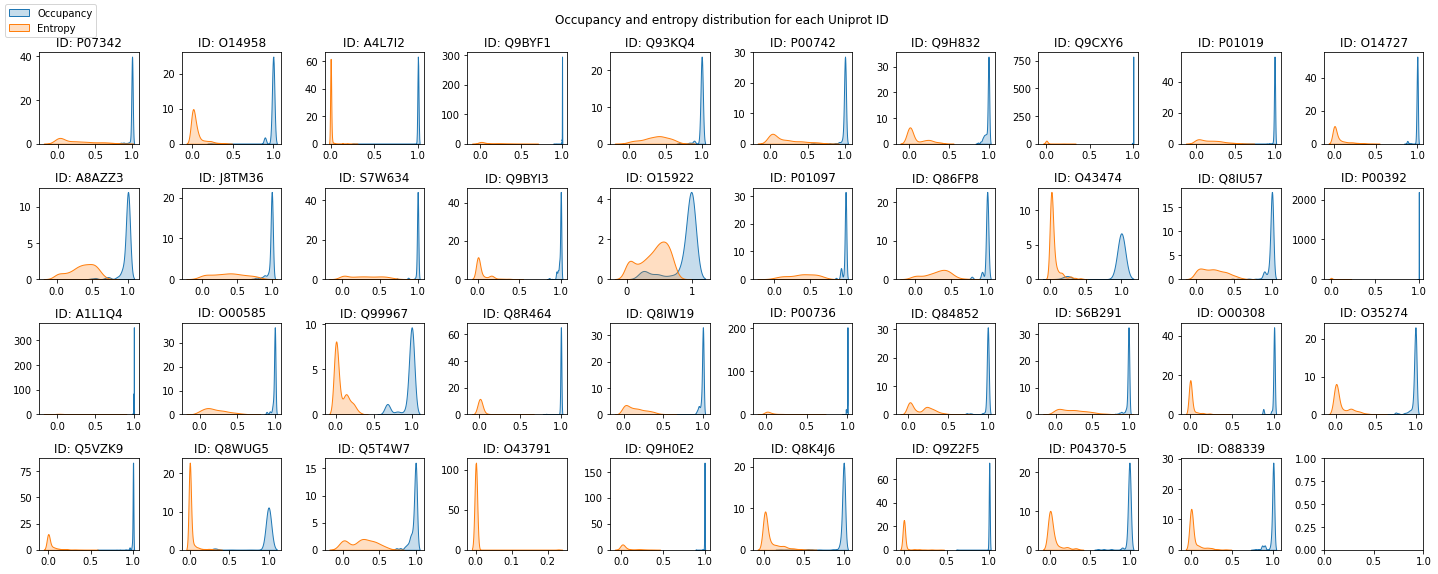

In [18]:
# Plot the statistics distribution for BLAST
plot_occupancy_entropy_distribution(blast_stats)

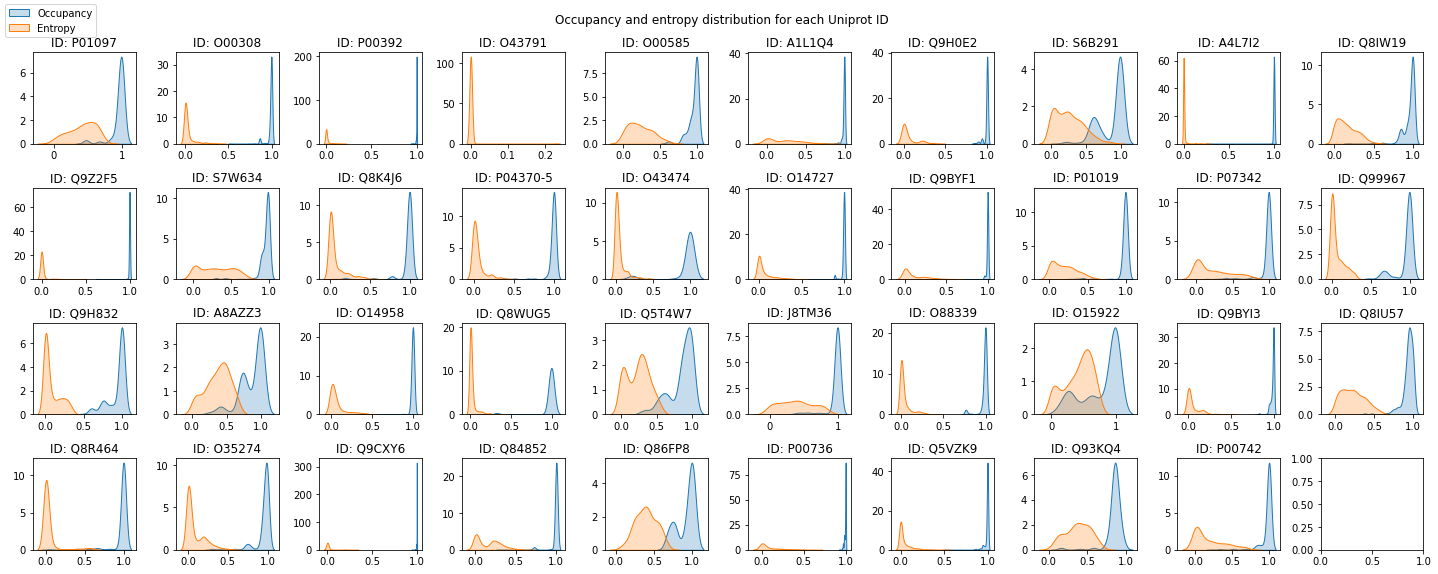

In [19]:
# Plot the statistics distribution for ClustalOmega
plot_occupancy_entropy_distribution(clustal_stats)

In [20]:
# # KDE plot of occupancy/entropy BLAST/ClustalOmega
# fig, ax = plt.subplots(2, 2, figsize=(10, 6))

# sns.kdeplot(blast_stats['occupancy'], shade = True, ax = ax[0,0])
# sns.kdeplot(clustal_stats['occupancy'], shade = True, ax = ax[0,0])

# sns.kdeplot(blast_stats['entropy'], shade = True, ax = ax[0,1])
# sns.kdeplot(clustal_stats['entropy'], shade = True, ax = ax[0,1])

# # Histogram of occupancy/entropy redundant vs non-redundant
# ax[1,0].hist([blast_stats['occupancy'], clustal_stats['occupancy']])
# ax[1,1].hist([blast_stats['entropy'], clustal_stats['entropy']])

# # Add x-axis labels to all subplots
# x_axis_labels = ['Occupancy', 'Entropy']
# for i in range(2):
#     for j in range(2):
#         ax[i, j].set_xlabel(x_axis_labels[j])

# # Add the common legend (assuming you have already done this)
# legend_labels = [f'BLAST', 
#                  f'ClustalOmega']

# for ax in ax.flat:
#     ax.legend(legend_labels)

# plt.suptitle(f'KDE plot and histogram of occupancy and entropy distribution')
# plt.tight_layout()
# plt.show()

In [21]:
# # KDE plot of occupancy/entropy redundant vs non-redundant - ClustalOmega
# fig, ax = plt.subplots(2, 2, figsize=(10, 6))

# sns.kdeplot(clustal_stats['occupancy'], shade = True, ax = ax[0,0])
# sns.kdeplot(nr_calc['occupancy'], shade = True, ax = ax[0,0])

# sns.kdeplot(clustal_stats['entropy'], shade = True, ax = ax[0,1])
# sns.kdeplot(nr_calc['entropy'], shade = True, ax = ax[0,1])

# # Histogram of occupancy/entropy redundant vs non-redundant
# ax[1,0].hist([clustal_stats['occupancy'], nr_calc['occupancy']])
# ax[1,1].hist([clustal_stats['entropy'], nr_calc['entropy']])

# # Add x-axis labels to all subplots
# x_axis_labels = ['Occupancy', 'Entropy']
# for i in range(2):
#     for j in range(2):
#         ax[i, j].set_xlabel(x_axis_labels[j])

# # Add the common legend (assuming you have already done this)
# legend_labels = [f'Initial ClustalW MSA', 
#                  f'Nr ClustalW MSA']
    
# for i in range(2):
#     for j in range(2):
#         legend = ax[i, j].legend(legend_labels, loc='upper left' if j == 0 else 'upper right')
#         ax[i, j].add_artist(legend)

# plt.suptitle(f'Occupancy and entropy distribution for {id_split} protein')
# plt.tight_layout()
# plt.show()